In [ ]:
import deerlab as dl
from matplotlib import pyplot as plt
import numpy as np

path = '../data/'
fname = '(CuNO_2p5)_40K_(RIDME_5P_Q)detNO_12-24_d2_1.5us_d4_8-to-64us_s8.DTA'

d3 = 0.28 # us
Tmix_axis = [8, 16, 32, 64] # mixing times, us

# 2D-Data loading and adjusting
# `a` is a list where a[0] is the RIDME time axis and a[1] is a list of mixing times in us
a,V = dl.deerload(path+fname)
Vexp = np.real(V)
Vexp /= np.max(Vexp)

t = a[0] + d3
Ntmix = len(a[1]) # number of points along the 2nd dimension (mixing times)

r = np.arange(1.5, 4, 0.02) # a common distance axis
# Next line is valid in DeerLab v1.1.0 or later
# In DeerLab v1.0 or smaller use dl.ex_4pdeer instead
myridme = dl.ex_ridme(0.4, 1.5, [1], 0.024) 
Vmodel = dl.dipolarmodel(t, r, experiment=myridme, Bmodel=dl.bg_strexp)

In [2]:
results = [] # collection of fit results for post-analysis
mod_depths = np.zeros((Ntmix, )) # list of modulation depths
md_uncerts = np.zeros((Ntmix, 2)) # uncertainties of modulation depths
bckgs = [] # backgrounds

for i in range(Ntmix):
    Vtofit = Vexp[:, i]
    result = dl.fit(Vmodel, Vtofit)
    results.append(result)
    mod_depths[i] = result.mod
    md_uncerts[i] = result.modUncert.ci(50)
    Bfcn = lambda decay,stretch,reftime: dl.bg_strexp(t-reftime,decay,stretch)
    Bfit = result.evaluate(Bfcn) # reconstructing the background
    bckgs.append(Bfit)


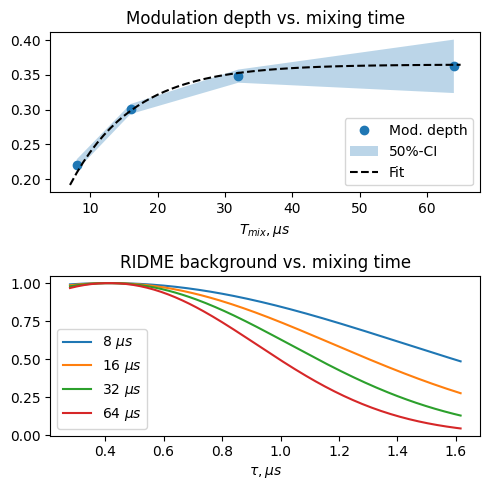

In [3]:
# Plotting
#==========
plt.figure(0, [5, 5])

# Modulation depth vs. mixing time
plt.subplot(211)
plt.plot(Tmix_axis, mod_depths, 'o')
plt.fill_between(Tmix_axis, md_uncerts[:, 0], md_uncerts[:, 1], alpha=0.3)

t_axis = np.arange(7, 66, 1) # dense axis for mixing times
T1 = 9.4 # us, T1-relaxation time of Cu, from inversion-recovery
md_fit = 0.365*(1-np.exp(-t_axis/T1)) # empirical fit of modulation depth
plt.plot(t_axis, md_fit, 'k--')
plt.xlabel(r'$T_{mix}, \mu s$')
plt.legend(['Mod. depth', r'50%-CI', 'Fit'])
plt.title("Modulation depth vs. mixing time")

# Background shape vs. mixing times
plt.subplot(212)
for b in bckgs:
    plt.plot(t, b)
plt.xlabel(r'$\tau, \mu s$')
plt.legend([str(Tmix)+r' $\mu s$' for Tmix in Tmix_axis])
plt.title("RIDME background vs. mixing time")

plt.tight_layout()
plt.show()